# LLM Evaluation

## What Will We Do? 
* Create an eval prompt template (notebook 4a) 
* Create two different RAG prompt templates and compare results (notebook 4a) 
* Run LLM-As-A-Judge against an eval dataset and grade RAG system response (notebook 4a) 
* Run Human-Eval to ensure LLM-As-A-Judge is aligned with human preferences (notebook 4b) 
* Run Human-Eval and compare GroundTruth with RAG system response (notebook 4b)
* **Run through evaluation with different LLMs (notebook 4c)**

So let's start.

### Install Dependencies

In [7]:
# !conda create -y --name llm-system-eval python=3.11.7
# !conda init && activate llm-system-eval
# !conda install -n llm-system-eval ipykernel --update-deps --force-reinstall -y
# OR
# !pyenv virtualenv 3.11.7 llm-system-eval
# !pyenv activate llm-system-eval

# %pip install -r requirements.txt

### Set Environment Variables

In [8]:
# set variables
from dotenv import load_dotenv, find_dotenv
import os
import sagemaker

import chromadb
import boto3
from chromadb.config import Settings

# loading environment variables that are stored in local file
local_env_filename = 'llm-system-eval.env'
load_dotenv(find_dotenv(local_env_filename),override=True)
os.environ['REGION'] = os.getenv('REGION')
REGION = os.environ['REGION']
os.environ['WORKTEAM_ARN'] = os.getenv('WORKTEAM_ARN')
WORKTEAM_ARN = os.environ['WORKTEAM_ARN']
os.environ['S3_BUCKET_NAME'] = os.getenv('S3_BUCKET_NAME')
S3_BUCKET_NAME = os.environ['S3_BUCKET_NAME']
os.environ['SAGEMAKER_ROLE_ARN'] = os.getenv('SAGEMAKER_ROLE_ARN')
SAGEMAKER_ROLE_ARN = os.environ['SAGEMAKER_ROLE_ARN'] # OR sagemaker.get_execution_role()


# Initialize Chroma client
chroma_client = chromadb.Client(Settings(persist_directory="./chroma_db"))

# Also initialize the bedrock client so we can call some embedding models!
session = boto3.Session(profile_name='default')
bedrock_runtime_client = boto3.client('bedrock-runtime')

sagemaker_session = sagemaker.Session()
sagemaker_client = boto3.client('sagemaker')
role_name = SAGEMAKER_ROLE_ARN.split("/")[-1]

bucket = sagemaker_session.default_bucket()
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')


# Specify ARNs for resources needed to run an text classification job.
ac_arn_map = {
    "us-west-2": "081040173940",
    "us-east-1": "432418664414",
    "us-east-2": "266458841044",
    "eu-west-1": "568282634449"
}
# PreHumanTaskLambdaArn for text classification(single)
prehuman_arn = "arn:aws:lambda:{}:{}:function:PRE-PassThrough".format(
    REGION, ac_arn_map[REGION]
)

# AnnotationConsolidationConfig for text classification(single)
acs_arn = "arn:aws:lambda:{}:{}:function:ACS-PassThrough".format(REGION, ac_arn_map[REGION])

print(prehuman_arn)
print(acs_arn)

arn:aws:lambda:us-east-1:432418664414:function:PRE-PassThrough
arn:aws:lambda:us-east-1:432418664414:function:ACS-PassThrough


In [9]:
# ANSWER validation helper classes

import numpy as np
import pandas as pd
import json
import os
import boto3
from botocore.config import Config
import io
from io import StringIO
import time
import re
import typing as t
from queue import Queue
from threading import Thread
from numpy.linalg import norm
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

class Util():
    def __init__(self,
        debug: bool = False

    ):

        self.debug = debug
        self.wrapper = BedrockLLMWrapper(model_id='anthropic.claude-3-sonnet-20240229-v1:0', temperature=0,max_token_count=1000)

    REASONING_PATTERN = r'<thinking>(.*?)</thinking>'
    SCORE_PATTERN = r'<score>(.*?)</score>'
    ANSWER_PATTERN = r'<question_answer>(.*?)</question_answer>'

    # Strip out the portion of the response with regex.
    def extract_with_regex(self, response, regex):
        matches = re.search(regex, response, re.DOTALL)
        # Extract the matched content, if any
        return matches.group(1).strip() if matches else None

    def format_results(self, grade: str, chat_conversation: list[dict]) -> dict:
        reasoning: str = self.extract_with_regex(grade, self.REASONING_PATTERN)
        score: str =  self.extract_with_regex(grade, self.SCORE_PATTERN)
        
        return {
            'chat_conversation': chat_conversation,
            'reasoning': reasoning,
            'score': score
        }

    def compare_results(self, answer_results1, answer_results2):
        

        # # Function to convert 'score' column
        def convert_score(df):
            # df['score'] = df['score'].map({'correct': 1, 'incorrect': 0})
            df['score'] = pd.to_numeric(df['score'], errors='coerce').fillna(0).astype(int)
            return df

        # Apply the conversion to both dataframes
        answer_results1 = convert_score(answer_results1)
        answer_results2 = convert_score(answer_results2)

        # Calculate the average values for each metric
        metrics = ['score', 'faithfulness' ,'answer_relevancy', 'latency', 'cost']
        avg_results1 = [answer_results1[metric].mean() for metric in metrics]
        avg_results2 = [answer_results2[metric].mean() for metric in metrics]

        # Calculate percentage change, handling divide-by-zero and infinite cases
        def safe_percent_change(a, b):
            if pd.isna(a) or pd.isna(b):
                return 0
            if a == 0 and b == 0:
                return 0
            elif a == 0:
                return 100  # Arbitrarily set to 100% increase if original value was 0
            else:
                change = (b - a) / a * 100
                return change if np.isfinite(change) else 0

        percent_change = [safe_percent_change(a, b) for a, b in zip(avg_results1, avg_results2)]

        # Set up the bar chart
        x = np.arange(len(metrics))
        width = 0.5

        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the bars
        bars = ax.bar(x, percent_change, width)

        # Customize the chart
        ax.set_ylabel('Percentage Change (%)')
        ax.set_title('Percentage Change in Metrics (Results 2 vs Results 1)')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)

        # Add a horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

        # Add value labels on top of each bar
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}%',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3 if height >= 0 else -3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom' if height >= 0 else 'top')

        autolabel(bars)

        # Color the bars based on positive (green) or negative (red) change
        # For latency & cost, reverse the color logic
        for bar, change, metric in zip(bars, percent_change, metrics):
            if metric == 'latency' or metric == 'cost':
                bar.set_color('green' if change <= 0 else 'red')
            else:
                bar.set_color('green' if change >= 0 else 'red')
            

        # Adjust layout and display the chart
        fig.tight_layout()
        plt.show()

    def calculate_faithfulness(self, answer, context, similarity_threshold=0.3):
        # Tokenize the answer into sentences (potential claims)
        claims = sent_tokenize(answer)
        
        # Get stop words as a list
        stop_words = list(stopwords.words('english'))
        
        # Initialize TfidfVectorizer
        vectorizer = TfidfVectorizer(stop_words=stop_words)
        
        # Fit the vectorizer on the context and claims
        all_text = [context] + claims
        tfidf_matrix = vectorizer.fit_transform(all_text)
        
        # Get the context vector (first row of the matrix)
        context_vector = tfidf_matrix[0]
        
        # Initialize counters
        total_claims = len(claims)
        # print(f'total_claims: {total_claims}')
        supported_claims = 0
        
        # Calculate similarity between each claim and the context
        for i, claim in enumerate(claims, start=1):
            claim_vector = tfidf_matrix[i]
            similarity = cosine_similarity(context_vector, claim_vector)[0][0]
            # print(f'similarity: {similarity}')
            # If similarity is above a threshold, consider it supported
            if similarity > similarity_threshold:  # You can adjust this threshold
                supported_claims += 1
        
        # Calculate faithfulness score
        faithfulness_score = supported_claims / total_claims if total_claims > 0 else 0
        rounded_score = round(faithfulness_score, 3)
        return rounded_score

    def calculate_answer_relevance(self, actual_question, generated_answer, n=3):

        # Step 1: Generate 'n' variants of the question using Amazon Bedrock
        prompt = f"""Human: 
        Given the following answer, generate {n} possible questions that could have led to this answer:

        Answer: {generated_answer}

        Generate {n} different questions.
        Assistant:
        """
        response = self.wrapper.generate(prompt)
        
        generated_questions = response[0]
        # mean_cosine_similarity = self.cosine_similarity(actual_question, generated_questions)

        # Step 2: Vectorize the actual question and generated questions
        vectorizer = TfidfVectorizer()
        all_questions = [actual_question] + generated_questions.split('\n')
        tfidf_matrix = vectorizer.fit_transform(all_questions)

        # Step 3: Calculate cosine similarity between actual question and each generated question
        actual_question_vector = tfidf_matrix[0]
        generated_questions_vectors = tfidf_matrix[1:]
        similarities = cosine_similarity(actual_question_vector, generated_questions_vectors)

        # Step 4: Calculate the mean cosine similarity
        mean_cosine_similarity = similarities.mean()
        rounded_score = round(mean_cosine_similarity, 3)
        return rounded_score
            
    

    def calculate_cost(self, usage, model_id):
        '''
        Takes the usage tokens returned by Bedrock in input and output, and coverts to cost in dollars.
        '''
        
        input_token_haiku = 0.25/1000000
        output_token_haiku = 1.25/1000000
        input_token_sonnet = 3.00/1000000
        output_token_sonnet = 15.00/1000000
        input_token_opus = 15.00/1000000
        output_token_opus = 75.00/1000000
        
        input_token_titan_embeddingv1 = 0.1/1000000
        input_token_titan_embeddingv2 = 0.02/1000000
        input_token_titan_embeddingmultimodal = 0.8/1000000
        input_token_titan_premier = 0.5/1000000
        output_token_titan_premier = 1.5/1000000
        input_token_titan_lite = 0.15/1000000
        output_token_titan_lite = 0.2/1000000
        input_token_titan_express = 0.2/1000000
        output_token_titan_express = 0.6/1000000
       
        input_token_cohere_command = 0.15/1000000
        output_token_cohere_command = 2/1000000
        input_token_cohere_commandlight = 0.3/1000000
        output_token_cohere_commandlight = 0.6/1000000
        input_token_cohere_commandrplus = 3/1000000
        output_token_cohere_commandrplus = 15/1000000
        input_token_cohere_commandr = 5/1000000
        output_token_cohere_commandr = 1.5/1000000
        input_token_cohere_embedenglish = 0.1/1000000
        input_token_cohere_embedmultilang = 0.1/1000000

        input_token_llama3_8b = 0.4/1000000
        output_token_llama3_8b = 0.6/1000000
        input_token_llama3_70b = 2.6/1000000
        output_token_llama3_70b = 3.5/1000000

        input_token_mistral_8b = 0.15/1000000
        output_token_mistral_8b = 0.2/1000000
        input_token_mistral_large = 4/1000000
        output_token_mistral_large = 12/1000000

        cost = 0

        if 'haiku' in model_id:
            cost+= usage['inputTokens']*input_token_haiku
            cost+= usage['outputTokens']*output_token_haiku
        if 'sonnet' in model_id:
            cost+= usage['inputTokens']*input_token_sonnet
            cost+= usage['outputTokens']*output_token_sonnet
        if 'opus' in model_id:
            cost+= usage['inputTokens']*input_token_opus
            cost+= usage['outputTokens']*output_token_opus
        if 'amazon.titan-embed-text-v1' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv1
        if 'amazon.titan-embed-text-v2' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv2
        if 'cohere.embed-multilingual' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedmultilang
        if 'cohere.embed-english' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedenglish 
        if 'meta.llama3-8b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_8b
            cost+= usage['outputTokens']*output_token_llama3_8b
        if 'meta.llama3-70b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_70b
            cost+= usage['outputTokens']*output_token_llama3_70b
        if 'cohere.command-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_command
            cost+= usage['outputTokens']*output_token_cohere_command
        if 'cohere.command-light-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandlight
            cost+= usage['outputTokens']*output_token_cohere_commandlight
        if 'cohere.command-r-plus' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandrplus
            cost+= usage['outputTokens']*output_token_cohere_commandrplus
        if 'cohere.command-r' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandr
            cost+= usage['outputTokens']*output_token_cohere_commandr
        if 'amazon.titan-text-express' in model_id:
            cost+= usage['inputTokens']*input_token_titan_express
            cost+= usage['outputTokens']*output_token_titan_express
        if 'amazon.titan-text-lite' in model_id:
            cost+= usage['inputTokens']*input_token_titan_lite
            cost+= usage['outputTokens']*output_token_titan_lite
        if 'amazon.titan-text-premier' in model_id:
            cost+= usage['inputTokens']*input_token_titan_premier
            cost+= usage['outputTokens']*output_token_titan_premier
        if 'mistral.mixtral-8x7b-instruct-v0:1' in model_id:
            cost+= usage['inputTokens']*input_token_mistral_8b
            cost+= usage['outputTokens']*output_token_mistral_8b

        return cost

class BedrockLLMWrapper():
    def __init__(self,
        model_id: str = 'anthropic.claude-3-haiku-20240307-v1:0',
        top_k: int = 5,
        top_p: int = 0.7,
        temperature: float = 0.0,
        max_token_count: int = 4000,
        max_attempts: int = 3,
        debug: bool = False,
        region: str ='us-east-1'

    ):

        self.model_id = model_id
        self.top_k = top_k
        self.top_p = top_p
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.max_attempts = max_attempts
        self.region = region
        self.debug = debug
        config = Config(
            retries = {
                'max_attempts': 10,
                'mode': 'standard'
            }
        )

        self.bedrock_runtime = boto3.client(service_name="bedrock-runtime", config=config, region_name=self.region)
    
    def get_embedding(self, body, modelId, accept, contentType):
        response = self.bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
        response_body = json.loads(response.get('body').read())
        embedding = response_body.get('embedding')
        return embedding
    
    def generate(self,prompt):
        if self.debug: 
            print('entered BedrockLLMWrapper generate')
        attempt = 1

        message = {
            "role": "user",
            "content": [{"text": prompt}]
        }
        messages = []
        messages.append(message)
        
        # model specific inference parameters to use.
        if "anthropic" in self.model_id.lower():
            # system_prompts = [{"text": "You are a helpful AI Assistant."}]
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                                "stopSequences": ["\n\nHuman:"],
                                "topP": self.top_p,
                            }
            additional_model_fields = {"top_k": self.top_k}
        else:
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                            }
            additional_model_fields = {"top_k": self.top_k}

        if self.debug: 
            print("Sending:\nSystem:\n",str(system_prompts),"\nMessages:\n",str(messages))

        while True:
            try:

                # Send the message.
                response = self.bedrock_runtime.converse(
                    modelId=self.model_id,
                    messages=messages,
                    system=system_prompts,
                    inferenceConfig=inference_config,
                    additionalModelRequestFields=additional_model_fields
                )

                # Log token usage.
                text = response['output'].get('message').get('content')[0].get('text')
                usage = response['usage']
                latency = response['metrics'].get('latencyMs')

                if self.debug: 
                    print(f'text: {text} ; and token usage: {usage} ; and query_time: {latency}')    
                
                break
               
            except Exception as e:
                print("Error with calling Bedrock: "+str(e))
                attempt+=1
                if attempt>self.max_attempts:
                    print("Max attempts reached!")
                    result_text = str(e)
                    break
                else:#retry in 10 seconds
                    print("retry")
                    time.sleep(10)

        # return result_text
        return [text,usage,latency]

    # Threaded function for queue processing.
    def thread_request(self, q, results):
        while True:
            try:
                index, prompt = q.get(block=False)
                data = self.generate(prompt)
                results[index] = data
            except Queue.Empty:
                break
            except Exception as e:
                print(f'Error with prompt: {str(e)}')
                results[index] = str(e)
            finally:
                q.task_done()

    def generate_threaded(self, prompts, max_workers=15):
        results = [None] * len(prompts)
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_index = {executor.submit(self.generate, prompt): i for i, prompt in enumerate(prompts)}
            for future in as_completed(future_to_index):
                index = future_to_index[future]
                try:
                    results[index] = future.result()
                except Exception as exc:
                    print(f'Generated an exception: {exc}')
                    results[index] = str(exc)
        
        return results

class AnswerTaskRunner:
    def __init__(self, eval_df: pd.DataFrame, 
                 model_id:str = 'anthropic.claude-3-sonnet-20240229-v1:0',
                 eval_model_id:str = 'anthropic.claude-3-sonnet-20240229-v1:0',
                 temperature: float = 0.0,
                 max_token_count: int = 2000,
                 max_attempts: int = 3, 
                 prompt_template: str = '',
                 prompt_eval_template: str = ''):
        self.eval_df = eval_df
        self.model_id = model_id
        self.eval_model_id = eval_model_id
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.max_attempts = max_attempts
        self.prompt_template = prompt_template
        self.prompt_eval_template = prompt_eval_template
        self.wrapper = BedrockLLMWrapper(model_id=self.model_id, 
                                         max_token_count=self.max_token_count,
                                         temperature=self.temperature
                                         )
        self.eval_wrapper = BedrockLLMWrapper(model_id=self.eval_model_id, 
                                         max_token_count=self.max_token_count,
                                         temperature=self.temperature
                                         )

    def get_prompt(self, question, context_list):
        context = context_list
        prompt = self.prompt_template.format(question=question, context=context)
        return prompt

    def build_grader_prompt(self, original_query: str, llm_system_response: str, ground_truth_answer:str, context_list, answer_relevancy:str):
        context = context_list

        prompt = self.prompt_eval_template.format(
                        original_query= original_query,
                        llm_system_response= llm_system_response,
                        ground_truth_answer=ground_truth_answer,
                        context=context,
                        answer_relevancy = answer_relevancy,
                        
                    ) 
        return prompt

    def run(self) -> pd.DataFrame:
        df = pd.DataFrame(self.eval_df)
        util = Util()
        
        # Prepare prompts for answer generation
        answer_prompts = [self.get_prompt(row['query_text'], row['context']) for _, row in df.iterrows()]
        
        # Generate answers in parallel
        answer_responses = self.wrapper.generate_threaded(answer_prompts)
        
        eval_prompts = []
        for (_, row), response in zip(df.iterrows(), answer_responses):
            query = row['query_text']
            groundtruth_answer = row['question_answer']
            retrieved_chunks = row['context']
            
            generated_answer = util.extract_with_regex(str(response[0]), util.ANSWER_PATTERN)
            
            answer_relevancy = util.calculate_answer_relevance(query, generated_answer) if generated_answer else 0
            
            eval_prompts.append(self.build_grader_prompt(query, generated_answer, groundtruth_answer, retrieved_chunks, answer_relevancy))
        
        # Generate evaluations in parallel
        eval_responses = self.eval_wrapper.generate_threaded(eval_prompts)
        
        results = []
        for (_, row), answer_response, eval_response in zip(df.iterrows(), answer_responses, eval_responses):
            query = row['query_text']
            groundtruth_answer = row['question_answer']
            retrieved_chunks = row['context']
            
            generated_answer = util.extract_with_regex(str(answer_response[0]), util.ANSWER_PATTERN)
            
            reasoning = util.extract_with_regex(str(eval_response[0]), util.REASONING_PATTERN)
            score = util.extract_with_regex(str(eval_response[0]), util.SCORE_PATTERN)
            
            answer_relevancy = util.calculate_answer_relevance(query, generated_answer) if generated_answer else 0
            faithfulness = util.calculate_faithfulness(generated_answer, retrieved_chunks) if generated_answer else 0
            
            cost = util.calculate_cost(answer_response[1], self.model_id)
            
            result = {
                'query_text': query,
                'groundtruth_answer': groundtruth_answer,
                'retrieved_chunks': json.dumps(retrieved_chunks),
                'generated_answer': generated_answer,
                'usage': json.dumps(answer_response[1]),
                'latency': answer_response[2],
                'reasoning': str(reasoning),
                'score': score,
                'faithfulness': faithfulness,
                'answer_relevancy': answer_relevancy,
                'cost': cost,
            }
            results.append(result)
        
        return pd.DataFrame(results)

### LLM-as-a-Judge

In [10]:
# Prompt Evaluation Template
## this template could be improved by adding eval examples.

prompt_eval_template = """You are an expert judge evaluating the Retrieval Augmented Generation applications.
                   Your task is to evaluate a given answer based on a context and question using the criteria provided below.
 
                    Evaluation Criteria (Additive Score, 0-3):
                    1. Context: Award 1 point if the answer uses only information provided in the context, without introducing external or fabricated details.
                    2. Completeness: Add 1 point if the answer addresses all key elements of the question based on the available context, without omissions.
                    3. Conciseness: Add a final point if the answer uses the fewest words possible to address the question and avoids redundancy.
                    
                    Evaluation Steps:
                    1. Read provided context, question and answer carefully.
                    2. Go through each evaluation criterion one by one and assess whether the answer meets the criteria.
                    3. Compose your reasoning for each critera, explaining why you did or did not award a point. You can only award full points. 
                    4. Calculate the total score by summing the points awarded.
                    5. Think through the evaluation criteria inside <thinking></thinking> tags. 
                    Then, output the total score inside <score></score> tags.
                    Review your formatted response. It needs to be valid XML.

                    Now, please evaluate the following:

                    Question:
                    <original_query>
                    {original_query}
                    </original_query>

                    Generated answer:
                    <llm_system_response>
                    {llm_system_response}
                    </llm_system_response>

                    Ground truth answer:
                    <ground_truth_answer>
                    {ground_truth_answer}
                    </ground_truth_answer>

                    Context:
                    <context>
                    {context}
                    </context>

                    Here is the answer_relevancy score based of the original question and generated questions based of the generated answer.
                    <answer_relevancy>
                    {answer_relevancy}
                    </answer_relevancy>
                    The answer_relevancy score range between 0 and 1 where higher scores indicate better relevancy.
                
                    """

In [11]:
# LLM eval 1

EVAL_PATH = '../data/eval-datasets/4_answer_validation_opensearch.jsonl'
answer_eval_df = pd.read_json(EVAL_PATH,lines=True)

MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"
EVAL_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

prompt_template_claude_1 = """
        Human: 
        You are a helpful, respectful, and honest research assistant, dedicated to providing valuable and accurate information.
        You will be provided with a report extract between <report></report> XML tags, please read it and analyse the content.
        Please answer the following question: 
        {question} 
        
        The answer must only be based on the information from the context below.

        If a particular bit of information is not present, return "There is not enough information available to answer this question" inside the XML tags.
        Each returned answer should be concise, remove extra information if possible.
        The context will be given between <context></context> XML tags.

        <context>
        {context}
        </context>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

llm_results1: pd.DataFrame = AnswerTaskRunner(answer_eval_df,model_id=MODEL_ID,eval_model_id=EVAL_MODEL_ID, prompt_template=prompt_template_claude_1, prompt_eval_template=prompt_eval_template).run()
llm_results1.to_json('../data/eval-datasets/4_llm_validation_opensearch_graded1.jsonl', orient='records', lines=True)


In [12]:
# LLM eval 2
MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0"
EVAL_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

llm_results2: pd.DataFrame = AnswerTaskRunner(answer_eval_df,model_id=MODEL_ID, eval_model_id=EVAL_MODEL_ID, prompt_template=prompt_template_claude_1, prompt_eval_template=prompt_eval_template).run()
llm_results2.to_json('../data/eval-datasets/4_llm_validation_opensearch_graded2.jsonl', orient='records', lines=True)

### Review results

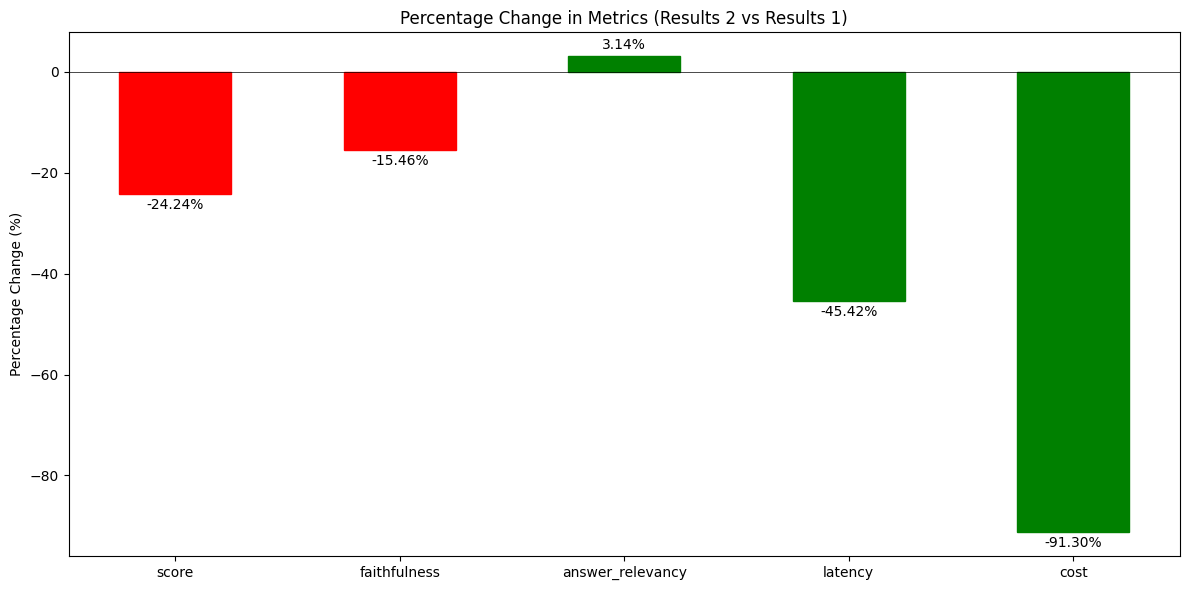

In [13]:
util = Util()
util.compare_results(llm_results1, llm_results2)

In [14]:
# Initial review of grades from LLM-as-a-Judge

llm_results1['score'] = llm_results1['score'].astype('int64')
llm_results2['score'] = llm_results2['score'].astype('int64')

def calculate_percentage_correct(df, threshold=2):
    total_count = len(df)
    correct_count = len(df[df['score'] > threshold])
    return (correct_count / total_count) * 100

percentage_correct1 = calculate_percentage_correct(llm_results1)
print(f"Percentage correct for answer_results1: {percentage_correct1:.2f}%")

percentage_correct2 = calculate_percentage_correct(llm_results2)
print(f"Percentage correct for answer_results2: {percentage_correct2:.2f}%")

# sample a subsection of 3 incorrect responses for answer_results1
from IPython.display import display, HTML

sample_size1 = 3 if len(llm_results1[(llm_results1['score'] <= 2)])  > 3 else len(llm_results1[(llm_results1['score'] <= 2)])
incorrect_rows = llm_results1[(llm_results1['score'] <= 2)].sample(n=sample_size1)
incorrect_rows_no_context = incorrect_rows.drop(columns=['retrieved_chunks'])
# Convert the dataframe to an HTML table
table_html = incorrect_rows_no_context.to_html(index=False, classes='table table-striped')
display(HTML(table_html))

# sample a subsection of 3 correct responses for answer_results1
sample_size2 = 3 if len(llm_results1[(llm_results1['score'] > 2)]) > 3 else len(llm_results1[(llm_results1['score'] > 2)])
correct_rows = llm_results1[(llm_results1['score'] > 2)].sample(n=sample_size2)
correct_rows_no_context = correct_rows.drop(columns=['retrieved_chunks'])
# Convert the dataframe to an HTML table
table_html = correct_rows_no_context.to_html(index=False, classes='table table-striped')
display(HTML(table_html))

Percentage correct for answer_results1: 75.00%
Percentage correct for answer_results2: 45.83%


query_text,groundtruth_answer,generated_answer,usage,latency,reasoning,score,faithfulness,answer_relevancy,cost
Can you show me some different examples of using different quantization methods for vectors?,"<question_answer>\nThere is not enough information available to answer this question. The context provides details on different quantization methods for vectors supported by the OpenSearch k-NN plugin, such as Lucene byte vectors, Lucene scalar quantization, Faiss 16-bit scalar quantization, and Faiss product quantization. However, it does not provide specific examples of using these methods.\n</question_answer>","There is not enough information available to answer this question. The given context provides details on different quantization methods for vectors supported by the OpenSearch k-NN plugin, such as Lucene byte vectors, Lucene scalar quantization, Faiss 16-bit scalar quantization, and Faiss product quantization. However, it does not provide specific examples of using these methods.","{""inputTokens"": 4639, ""outputTokens"": 96, ""totalTokens"": 4735}",4186,"Context:\n1. The context provides details on different quantization methods for vectors supported by the OpenSearch k-NN plugin, such as Lucene byte vectors, Lucene scalar quantization, Faiss 16-bit scalar quantization, and Faiss product quantization. However, it does not provide specific examples of using these methods.\n\nCompleteness:\n1. The generated answer correctly states that the context does not provide enough information to answer the question about showing examples of using different quantization methods for vectors. It addresses the key elements of the question based on the available context.\nScore: 1\n\nConciseness:\n1. The generated answer is concise and uses the fewest words possible to address the lack of information in the context to answer the question.\nScore: 1",2,0.333,0.088,0.015357
"What specific Java permission is required to register and unregister MBeans when installing the anomaly detection plugin, and what exact object does this permission apply to?","<question_answer>\nThe specific Java permission required to register and unregister MBeans when installing the anomaly detection plugin is:\n\njavax.management.MBeanPermission org.apache.commons.pool2.impl.GenericObjectPool#-[org.apache.commons.pool2:name=pool,type=GenericObjectPool] registerMBean\njavax.management.MBeanPermission org.apache.commons.pool2.impl.GenericObjectPool#-[org.apache.commons.pool2:name=pool,type=GenericObjectPool] unregisterMBean\n\nThis permission applies to the org.apache.commons.pool2.impl.GenericObjectPool object.\n</question_answer>","The specific Java permission required to register and unregister MBeans when installing the anomaly detection plugin is:\n\njavax.management.MBeanPermission org.apache.commons.pool2.impl.GenericObjectPool#-[org.apache.commons.pool2:name=pool,type=GenericObjectPool] registerMBean\njavax.management.MBeanPermission org.apache.commons.pool2.impl.GenericObjectPool#-[org.apache.commons.pool2:name=pool,type=GenericObjectPool] unregisterMBean\n\nThis permission applies to the org.apache.commons.pool2.impl.GenericObjectPool object.","{""inputTokens"": 5220, ""outputTokens"": 165, ""totalTokens"": 5385}",5596,"Context:\n1. The context does not provide any information about the specific Java permission required to register and unregister MBeans when installing the anomaly detection plugin. The answer appears to be using information not present in the given context, so I will not award a point for this criterion.\n\nCompleteness:\n2. The answer directly addresses the question by providing the specific Java permissions required to register and unregister MBeans for the anomaly detection plugin, as well as the object to which these permissions apply. It covers all key elements of the question, so I will award 1 point for completeness.\n\nConciseness:\n3. The answer is concise and uses the fewest words necessary to address the question without

query_text,groundtruth_answer,generated_answer,usage,latency,reasoning,score,faithfulness,answer_relevancy,cost
What is the difference between vector search and full text search?,"<question_answer>\nThe main difference between vector search and full text search is:\n\nVector search is used to find similar or semantically related documents to a given query, based on vector representations of the text. It calculates the similarity between the query vector and document vectors, and returns the most similar documents.\n\nFull text search is used to find documents that contain the exact words or terms in the query. It analyzes the query text and matches it against an inverted index of terms in the documents, returning documents that contain those terms.\n\nThere is not enough information available in the given context to explain the difference between vector search and full text search.\n</question_answer>","The main difference between vector search and full text search is:\n\nVector search is used to find similar or semantically related documents to a given query, based on vector representations of the text. It calculates the similarity between the query vector and document vectors, and returns the most similar documents.\n\nFull text search is used to find documents that contain the exact words or terms in the query. It analyzes the query text and matches it against an inverted index of terms in the documents, returning documents that contain those terms.\n\nThere is not enough information available in the given context to explain the difference between vector search and full text search.","{""inputTokens"": 2587, ""outputTokens"": 143, ""totalTokens"": 2730}",6874,"Context:\n1. The context provides a detailed explanation of the difference between vector search and full text search, covering aspects like how they work, what they are used for, and how they handle relevance scoring. Since the generated answer accurately reflects the information in the context without introducing any external details, I will award 1 point for this criterion.\n\nCompleteness:\n2. The generated answer comprehensively addresses the key elements of the question by explaining the main difference between vector search and full text search, including how they handle similarity/relevance scoring and exact term matching. It covers all the important points mentioned in the context. Therefore, I will award 1 point for completeness.\n\nConciseness:\n3. The generated answer is concise and uses the fewest words necessary to address the question without redundancy. It directly states the main difference and provides supporting details in a clear and succinct manner. I will award 1 point for conciseness.",3,0.00,0.213,0.009906
"I have a custom model, can I run it in Opensearch?","<question_answer>\nYes, you can run your custom model in OpenSearch. The documentation provides instructions on how to register and deploy a custom model in OpenSearch. You need to provide the model file URL, model configuration details like model type and embedding dimension, and other metadata to register the model. Once registered, you can deploy the model and use it for inference tasks like text embedding or neural search.\n</question_answer>","Yes, you can run your custom model in OpenSearch. The documentation provides instructions on how to register and deploy a custom model in OpenSearch. You need to provide the model file URL, model configuration details like model type and embedding dimension, and other metadata to register the model. Once registered, you can deploy the model and use it for inference tasks like text embedding or neural search.","{""inputTokens"": 12282, ""outputTokens"": 92, ""totalTokens"": 12374}",9332,"1. Context: The context provides detailed information about registering and deploying models in OpenSearch, including custom models, pretrained models, and models hosted on third-party platforms. It covers the required parameters, configuration options, and examp

# Takeaways
* If accuracy as evaluated by LLM-as-a-Judge remains similar, but other metrics such as cost and latency improve, then the alternative LLM (e.g. Haiku) is a viable option.

### SCRATCHPAD

In [15]:
# Bedrock LLM eval example

import boto3
import random
import string

bedrock_client = boto3.client('bedrock',region_name=REGION)
sagemaker_client = boto3.client('sagemaker',region_name=REGION)

# Generate the random string
random_string = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(6)).lower()

create_flow_definition_response = sagemaker_client.create_flow_definition(
    FlowDefinitionName= f'human-eval-task-{random_string}',
    HumanLoopRequestSource={
        'AwsManagedHumanLoopRequestSource': 'AWS/Bedrock/Evaluation'
    },

    HumanLoopConfig={
        'WorkteamArn': WORKTEAM_ARN,
        'HumanTaskUiArn': f'arn:aws:sagemaker:{REGION}:394669845002:human-task-ui/Evaluation',
        'TaskTitle': 'Human review tasks',
        'TaskDescription': 'Determine best answer',
        'TaskCount': 1,
        'TaskAvailabilityLifetimeInSeconds': 864000,
        'TaskTimeLimitInSeconds': 3600,
        'TaskKeywords': [
            'evaluation',
        ],
        
    },
    OutputConfig={
        'S3OutputPath': f's3://{S3_BUCKET_NAME}/eval',
    },
    RoleArn=SAGEMAKER_ROLE_ARN,
    Tags=[
        {
            'Key': 'eval',
            'Value': 'human-eval'
        },
    ]
)

flow_definition = create_flow_definition_response.get('FlowDefinitionArn')



create_evaluation_job_response = bedrock_client.create_evaluation_job(
    jobName=f'human-eval-{random_string}',
    jobDescription="Evaluate answer generated with different prompt templates",
    roleArn=SAGEMAKER_ROLE_ARN,
    inferenceConfig={
        # array of models to be evaluated
        "models": [
            {
                "bedrockModel": {
                    "modelIdentifier":f"arn:aws:bedrock:{REGION}::foundation-model/mistral.mixtral-8x7b-instruct-v0:1",
                    "inferenceParams":"{\"temperature\":\"0.0\", \"topP\":\"1\", \"maxTokenCount\":\"512\"}"
                }
            }
        
            # {
            #     "bedrockModel": {
            #         "modelIdentifier":f"arn:aws:bedrock:{region}::foundation-model/amazon.titan-text-lite-v1",
            #         "inferenceParams":"{\"temperature\":\"0.25\", \"topP\":\"1\", \"maxTokenCount\":\"256\"}"
            #     }

            # },
            
        ]

    },
    outputDataConfig={
        "s3Uri":f"s3://{S3_BUCKET_NAME}/evalresults/"
    },
    evaluationConfig={
        "human": {
        "humanWorkflowConfig": {
            "flowDefinitionArn": f"{flow_definition}",
            "instructions": "Review the generated answers"
        },
        "customMetrics": [
            {
                "name": "HumanPreference",
                "description": "human preference",
                "ratingMethod": "IndividualLikertScale"
            }
        ],
        "datasetMetricConfigs": [
            {
                "taskType": "Generation",
                "dataset": {
                    "name": "Custom_Dataset1",
                    "datasetLocation": {
                        "s3Uri": f"s3://{S3_BUCKET_NAME}/eval/data.jsonl"
                    }
                },
                "metricNames": [
                  "HumanPreference",
                ]
            }
        ]
      }

    }
)
eval_job = create_evaluation_job_response.get('jobArn')
print(f'eval_job: {eval_job}')

eval_job: arn:aws:bedrock:us-east-1:026459568683:evaluation-job/ziqk76cfgk50
